In [12]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf



In [13]:
def create_dataset():
    directory = "../../processed_data/train_set/"
    data= []
    label= []
    for i in range(1, 7):
        for filename in os.listdir(directory+str(i)):
            if filename.endswith(".png"):
                img = Image.open(directory+str(i)+"/"+filename)
                data.append(np.array(img))
                label.append(i-1)
            if len(data)% 100 ==0:
                break
    print(len(data))
    return data, label

In [14]:
data, labels= create_dataset() 

600


In [15]:
data = np.array(data)
data.shape

(600, 128, 128)

In [16]:
preprocessed_data = data/255
labels= np.array(labels).reshape(-1,1)

In [17]:
print("Drawings shape before : ", preprocessed_data.shape)
preprocessed_data = np.expand_dims(preprocessed_data, axis=3)
print("Drawings shape after : ", preprocessed_data.shape)
print("Label shape : ", labels.shape)

Drawings shape before :  (600, 128, 128)
Drawings shape after :  (600, 128, 128, 1)
Label shape :  (600, 1)


In [18]:
from sklearn.model_selection import train_test_split

# split data in train/val/test set
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    preprocessed_data, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels,
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)

In [19]:
def SSIMLoss(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [15]:
inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')


In [17]:
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.MaxPool2D(strides= 2)(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

In [18]:
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

In [19]:
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)


In [20]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

/home/admin1/anaconda3/envs/pytorch/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 64, 64, 32)       9248      
 nspose)                                                         
                                                                 
 conv_transpose_2 (Conv2DTra  (None, 128, 128, 32)     9248      
 nspose)                                                         
                                                             

In [15]:
# dot_img_file = '../assets/autoencoder.png'
# tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)

In [16]:
!rm -rf ./logs/


In [22]:
from keras.callbacks import TensorBoard


In [23]:
hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='logs/')])

Epoch 1/5


2022-02-09 11:33:54.548923: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 11:33:55.878670: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 11:34:09.529090: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


1/4 [======>.......................] - ETA: 1:09 - loss: 0.5699

2022-02-09 11:34:13.384762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 11:34:14.566144: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


4/4 [==============================] - 78s 18s/step - loss: 0.5101 - val_loss: 0.4369
Epoch 2/5
4/4 [==============================] - 74s 19s/step - loss: 0.4394 - val_loss: 0.4334
Epoch 3/5
4/4 [==============================] - 67s 17s/step - loss: 0.4385 - val_loss: 0.4334
Epoch 4/5
4/4 [==============================] - 60s 15s/step - loss: 0.4353 - val_loss: 0.4214
Epoch 5/5
4/4 [==============================] - 59s 15s/step - loss: 0.4221 - val_loss: 0.4127


In [24]:
# autoencoder = tf.keras.models.load_model('autoencoder.h5', custom_objects= {'loss':SSIMLoss(test_data, test_data)})

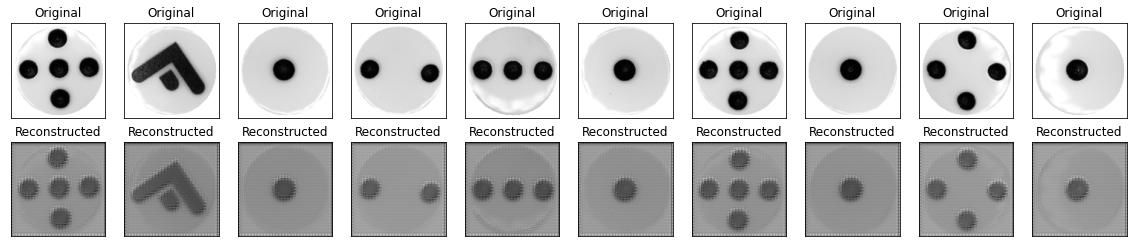

In [25]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
def create_dataset_ano():
    directory = "../../processed_data/train_set/ano"
    data= []
    label= []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = Image.open(directory+"/"+filename)
            data.append(np.array(img))
                
    print(len(data))
    return data

In [21]:
anomalies = create_dataset_ano()


56


In [22]:
anomalies = np.array(anomalies)

In [23]:
anomalies.shape


(56, 128, 128)

In [24]:
anomalies = np.expand_dims(anomalies,axis=3)

In [25]:
anomalies.shape

(56, 128, 128, 1)

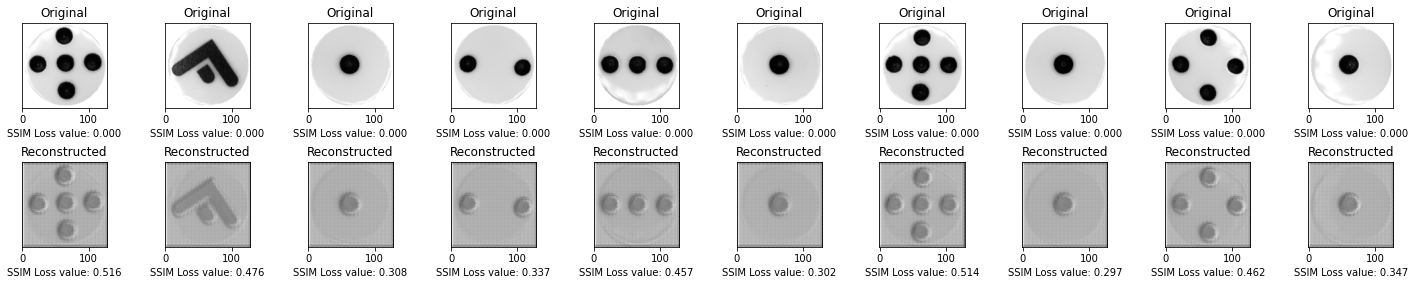

In [26]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()

In [26]:
anomalies = anomalies/255

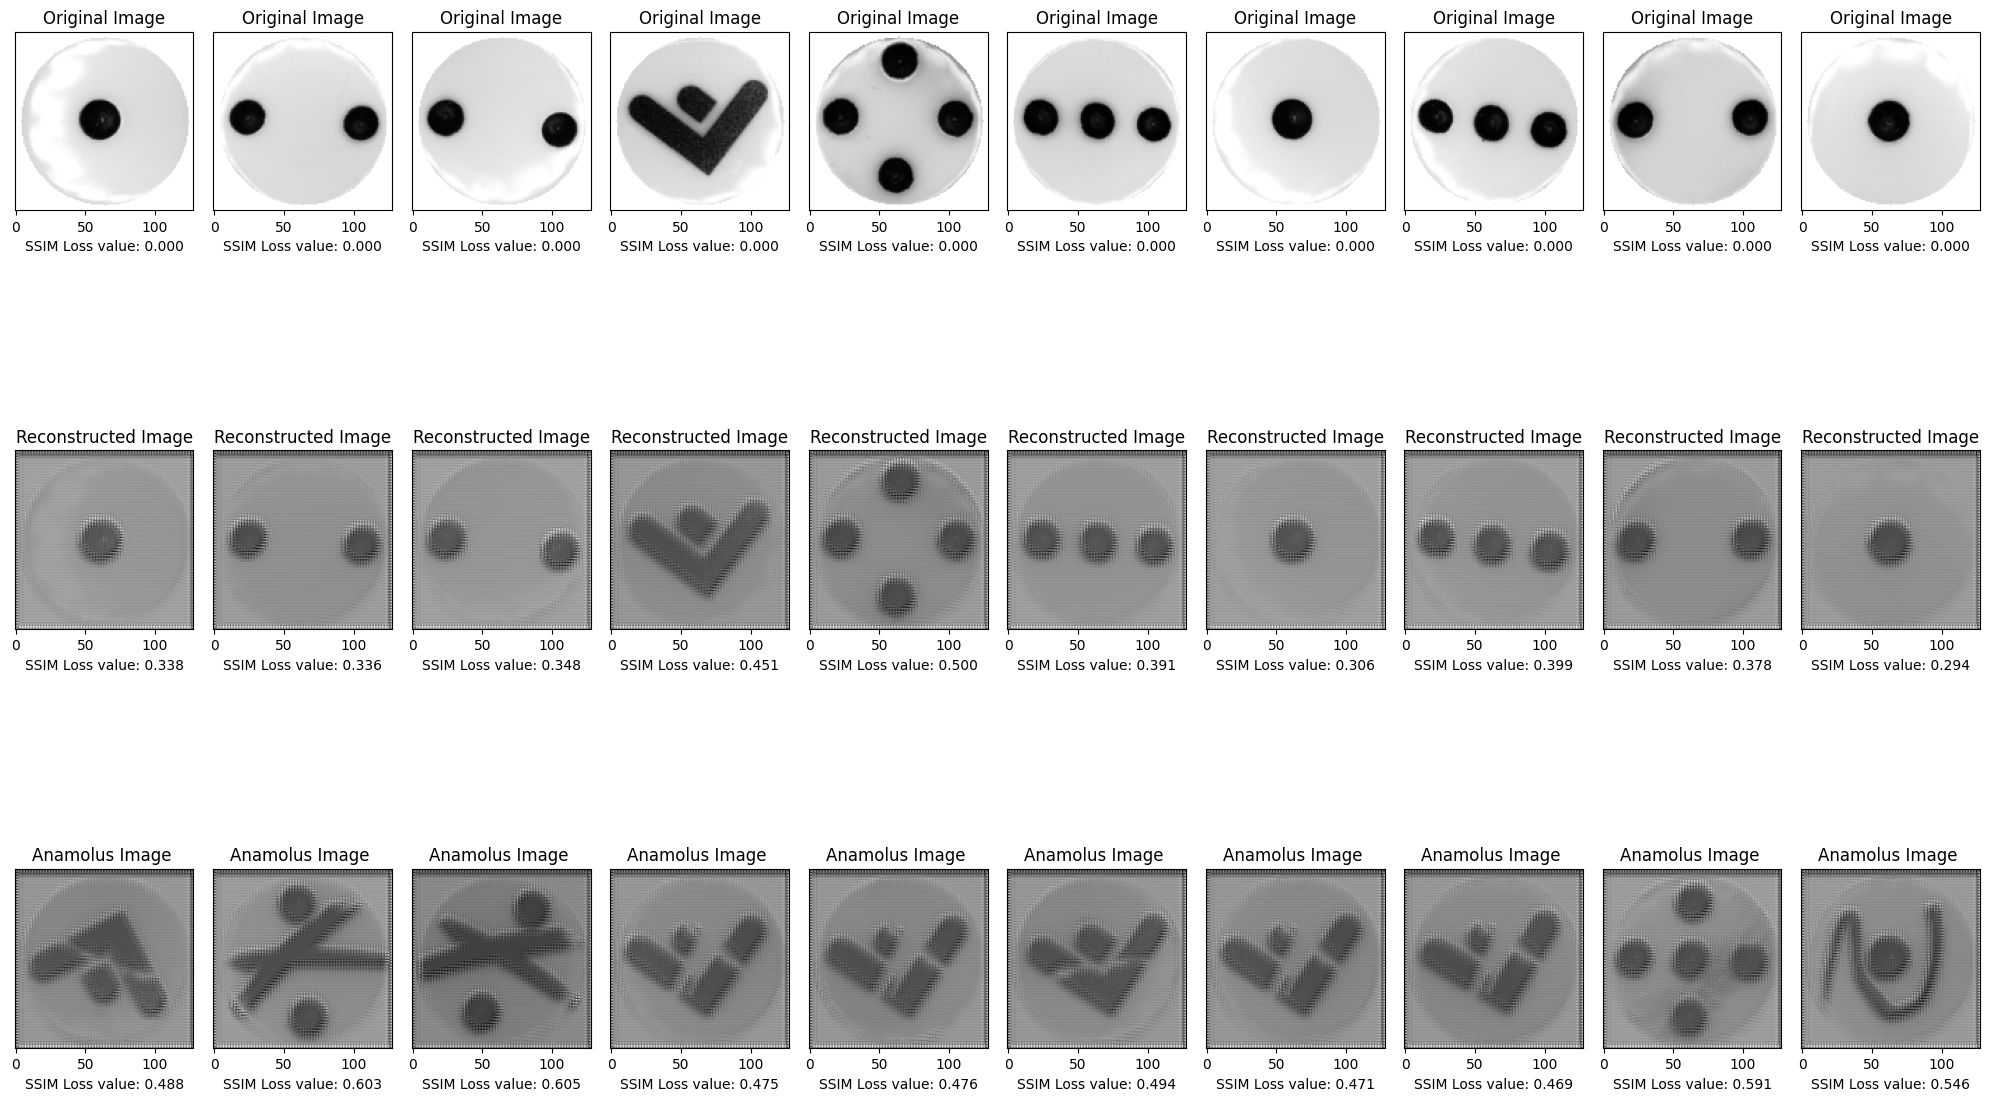

In [31]:
%matplotlib inline
n = 10 # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)

decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n, n+10):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

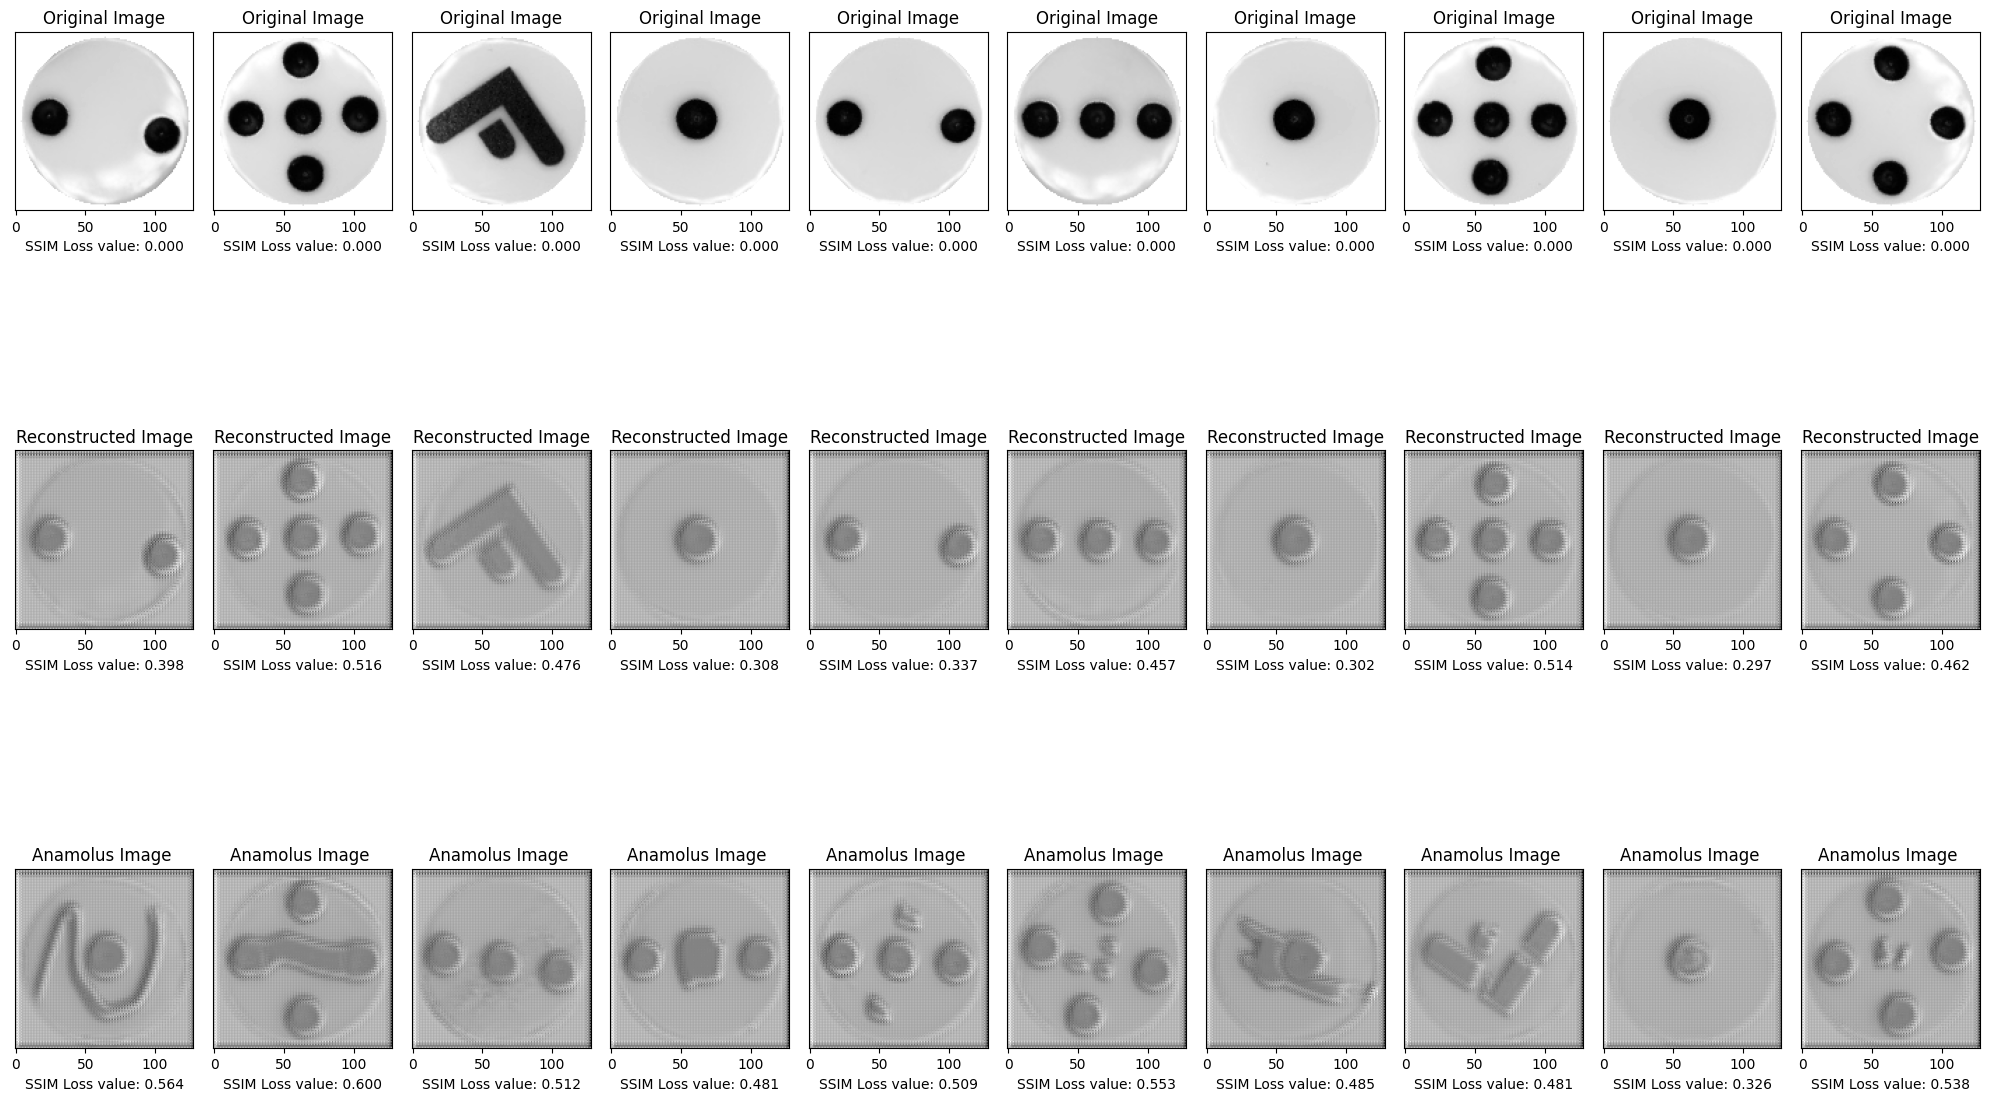

In [29]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

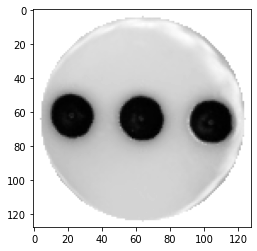

In [30]:
img = Image.open("../../processed_data/train_set/3/16_09_21_03_000.png")
plt.imshow(img, cmap="gray")
img = np.array(img)/255
decoded_imgs= autoencoder.predict(np.array([img.reshape(128, 128, 1)]))

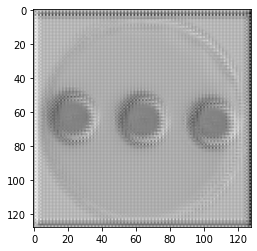

In [31]:
plt.imshow(decoded_imgs[0])

In [32]:
test_data.shape

(120, 128, 128, 1)

In [33]:
np.array([np.array(img).reshape(128, 128, 1)]).shape

(1, 128, 128, 1)

In [34]:
autoencoder.save("autoencoder.h5")


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tqdm

def print_stats(predictions, labels):
    """
    Coth prints the stats of the prediction, and returns them as an array

    :predictions: list containing predictions
    :labels: list containing labels
    :return: list containing floats f1, accuracy, precision, recall
    """
    f1 = f1_score(labels, predictions)
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)

    print("f1 = {}".format(f1_score(labels, predictions)))
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

    return [f1, acc, prec, rec]


def SSIMLoss(y_true, y_pred):
    """
    numpy version of the SSIM loss function

    :y_true: the original image before being processed
    :y_pred: the same image after being processed by the autoencoder moder
    :return: float between 0 and 1 giving a measure of distance between the 2 parameters
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


def predictor(ano_pred, norm_pred, threshold):
    """
    predictor classifies prediction by comparing with a threshold

    :ano_pred: a list containing the predictions for anomalies between 0 and 1
    :norm_pred: a list containing the predictions for the normal samples between 0 and 1
    :return; 2 lists, 1 containing prediction and the other containing the labels.
    """
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)

        else:
            predictions.append(0)

    return predictions, labels


def make_predictions(model, anomalies, normals):
    """
    Function implementing SSIMloss on the both anomalies and normal samples

    :model: autoencoder or any other model taking in 128x128 images
    :anomalies: list of np arrays of 128 x 128
    :normals: list of np arrays of 128 x 128
    :return: a list containing 4 metrics, f1, accuracy, precision, recall
    """
    ano_predictions = []
    norm_predictions = []
    for ano in anomalies:
#         print(ano.shape)
        result = model.predict(ano.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
#         print(result.shape)
        ano_predictions.append(SSIMLoss(ano, result).numpy())

    for sample in tqdm.tqdm(normals):
#         print(sample.shape)
        result = model.predict(sample.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        norm_predictions.append(SSIMLoss(sample, result).numpy())

    threshold = (
        np.mean(norm_predictions)
        + (np.mean(norm_predictions) + np.mean(ano_predictions)) / 12
    )

    predictions, labels = predictor(ano_predictions, norm_predictions, threshold)

    return print_stats(predictions, labels)


In [35]:
f1, acc, prec, rec= make_predictions(autoencoder, anomalies, test_data)

100%|██████████| 120/120 [00:30<00:00,  3.90it/s]

f1 = 0.6379310344827587
Accuracy = 0.7613636363636364
Precision = 0.6166666666666667
Recall = 0.6607142857142857


In [28]:
model = tf.keras.models.load_model('../../models/autoencoder.h5', compile=False)

In [29]:
make_predictions(model, anomalies, test_data)

100%|██████████| 120/120 [00:30<00:00,  3.98it/s]

f1 = 0.6379310344827587
Accuracy = 0.7613636363636364
Precision = 0.6166666666666667
Recall = 0.6607142857142857


[0.6379310344827587,
 0.7613636363636364,
 0.6166666666666667,
 0.6607142857142857]